In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('preprocessed.csv')

In [3]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

True
NVIDIA GeForce RTX 2050


In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, classification_report

# ===============================
# 🔧 Device Setup (GPU / CPU)
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ===============================
# 📊 Example Dataset (replace with your df)
# ===============================
df = pd.read_csv("preprocessed.csv")  # your actual dataset path
target_col = "CVDCRHD4"  # heart attack column (1=Yes, 2=No)

# Drop missing / unknown labels
df = df[df[target_col].isin([1, 2])]
df[target_col] = df[target_col].replace({1: 1, 2: 0})

# Split features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(exclude=["int64", "float64"]).columns

from imblearn.over_sampling import SMOTE

# ===============================
# 🧹 Preprocessing
# ===============================
numeric_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# Split before SMOTE (so test set is untouched)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

# ===============================
# ⚙️ Apply SMOTE to training data
# ===============================
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_res))

# Convert to tensors
X_train_tensor = torch.tensor(X_train_res, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_res.values, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)


# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ===============================
# 🧠 Model Definition
# ===============================
class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super(AttentionLayer, self).__init__()
        self.attn = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.Tanh(),
            nn.Linear(input_dim, 1)
        )

    def forward(self, x):
        attn_weights = torch.softmax(self.attn(x), dim=1)
        context = torch.sum(attn_weights * x, dim=1)
        return context

class MLPWithAttention(nn.Module):
    def __init__(self, input_dim):
        super(MLPWithAttention, self).__init__()
        self.attn = AttentionLayer(input_dim)
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        context = self.attn(x)
        out = self.net(x)
        return out

model = MLPWithAttention(X_train.shape[1]).to(device)

# ===============================
# ⚙️ Training Setup
# ===============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
epochs = 100

# ===============================
# 🚀 Training Loop
# ===============================
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# ===============================
# 🧾 Evaluation
# ===============================
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        preds = model(xb)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(torch.argmax(preds, dim=1).cpu().numpy())

acc = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print(f"\n✅ Accuracy: {acc*100:.2f}%")
print(f"📈 Recall: {recall*100:.2f}%")
print("\n📋 Classification Report:\n", classification_report(y_true, y_pred))


Using device: cuda


KeyError: 'had_attack'

In [5]:
df

,Unnamed: 0,CHECKUP1,EXERANY2,LASTDEN4,had_hattack,CVDCRHD4,ASTHMA3,CHCKDNY2,DIABETE4,WEIGHT2,...,drinks_frequency,_PHYS14D,_MENT14D,_HLTHPL2,_TOTINDA,_SEX,_AGE65YR,_BMI5CAT,Heavy_drinkers,Adult
0,2,4.0,1.0,4.0,2.0,0.0,2.0,2.0,3.0,195.0,...,3.0,3.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1
1,15,1.0,1.0,1.0,2.0,0.0,2.0,2.0,3.0,178.0,...,88.0,2.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1
2,25,2.0,2.0,2.0,2.0,0.0,1.0,2.0,3.0,217.0,...,88.0,3.0,1.0,1.0,2.0,2.0,1.0,4.0,1.0,1
3,32,1.0,2.0,1.0,2.0,0.0,2.0,2.0,3.0,146.0,...,88.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,1
4,37,1.0,1.0,3.0,2.0,0.0,2.0,2.0,4.0,200.0,...,88.0,1.0,1.0,1.0,1.0,2.0,2.0,4.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192164,428793,1.0,1.0,3.0,2.0,0.0,2.0,2.0,3.0,130.0,...,88.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1
192165,428796,2.0,1.0,1.0,2.0,0.0,2.0,2.0,3.0,200.0,...,88.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1
192166,428797,1.0,2.0,1.0,2.0,0.0,2.0,2.0,1.0,190.0,...,10.0,2.0,3.0,2.0,2.0,1.0,1.0,4.0,1.0,1
192167,428800,2.0,2.0,1.0,2.0,0.0,2.0,2.0,3.0,128.0,...,77.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1


In [10]:

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, roc_auc_score,recall_score,accuracy_score
from imblearn.over_sampling import SMOTE
import numpy as np



# ---------------- FOCAL LOSS CLASS ----------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss
# --------------------------------------------------

from sklearn.preprocessing import StandardScaler

# Split your data (if not done already)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42,
)

# 1️⃣ Initialize scaler
scaler = StandardScaler()

# 2️⃣ Fit only on training data, then transform both
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3️⃣ If using SMOTE after scaling:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train_scaled, y_train)


# ===============================
# ⚙️ 1️⃣ SMOTE Oversampling
# ===============================
smote = SMOTE(sampling_strategy=0.6, random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)
print("After SMOTE:", np.bincount(y_res))

# ===============================
# ⚙️ 2️⃣ Convert to Tensors
# ===============================
X_train_tensor = torch.tensor(X_res, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_res, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long).to(device)
# ===============================
# 🧠 3️⃣ Model Architecture (Enhanced)
# ===============================
class ImprovedMLP_Recall(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedMLP_Recall, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.25)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2)
        )
        self.layer4 = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.15)
        )
        self.output = nn.Linear(64, 2)

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        return self.output(x4)


# ===============================
# ⚙️ 4️⃣ Loss + Optimizer + Scheduler
# ===============================
class_counts = np.bincount(y_res)
weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
weights = weights / weights.sum()
weights = weights.to(device)

model = ImprovedMLP(X_train.shape[1]).to(device)

class_counts = np.bincount(y_res)
class_weights = torch.tensor(len(y_res) / (2.0 * class_counts), dtype=torch.float32).to(device)

criterion = FocalLoss(alpha=2.5, gamma=2)


optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

# ===============================
# 🚀 5️⃣ Training Loop with Early Stopping
# ===============================
best_loss = float('inf')
patience = 5
trigger = 0

epochs = 300
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    # Early stopping
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), "best_model.pt")
        trigger = 0
    else:
        trigger += 1
        if trigger >= patience:
            print("Early stopping triggered!")
            break

# ===============================
# 🧾 6️⃣ Evaluation with Threshold Tuning
# ===============================
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
with torch.no_grad():
    probs = torch.softmax(model(X_test_tensor), dim=1)[:, 1].cpu().numpy()

best_f1 = 0
best_t = 0.5
for t in np.arange(0.2, 0.7, 0.05):
    preds = (probs > t).astype(int)
    report = classification_report(y_test, preds, digits=3, output_dict=True)

    # Safely get F1 for class 1 (handle missing key)
    f1 = report.get('1', {}).get('f1-score', 0.0)

    if f1 > best_f1:
        best_f1 = f1
        best_t = t


print(f"\n✅ Best Threshold = {best_t:.2f}")
final_preds = (probs > best_t).astype(int)
print(classification_report(y_test, final_preds, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, probs))
print("recall:", recall_score(y_test,final_preds))
print("acc:", accuracy_score(y_test,final_preds))


C:\Users\abhia\AppData\Local\Temp\ipykernel_26880\3007079073.py:51: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  print("After SMOTE:", np.bincount(y_res))
C:\Users\abhia\AppData\Local\Temp\ipykernel_26880\3007079073.py:102: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  class_counts = np.bincount(y_res)
C:\Users\abhia\AppData\Local\Temp\ipykernel_26880\3007079073.py:109: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  class_counts = np.bincount(y_res)
c:\Users\abhia\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. Duri

After SMOTE: [145289  87173]
Epoch 1/300, Loss: 0.4587
Epoch 2/300, Loss: 0.4072
Epoch 3/300, Loss: 0.3727
Epoch 4/300, Loss: 0.3486
Epoch 5/300, Loss: 0.3313
Epoch 6/300, Loss: 0.3204
Epoch 7/300, Loss: 0.3127
Epoch 8/300, Loss: 0.3082
Epoch 9/300, Loss: 0.3057
Epoch 10/300, Loss: 0.3034
Epoch 11/300, Loss: 0.3030
Epoch 12/300, Loss: 0.3011
Epoch 13/300, Loss: 0.2989
Epoch 14/300, Loss: 0.2972
Epoch 15/300, Loss: 0.2953
Epoch 16/300, Loss: 0.2935
Epoch 17/300, Loss: 0.2927
Epoch 18/300, Loss: 0.2911
Epoch 19/300, Loss: 0.2909
Epoch 20/300, Loss: 0.2906
Epoch 21/300, Loss: 0.2899
Epoch 22/300, Loss: 0.2895
Epoch 23/300, Loss: 0.2891
Epoch 24/300, Loss: 0.2884
Epoch 25/300, Loss: 0.2871
Epoch 26/300, Loss: 0.2873
Epoch 27/300, Loss: 0.2858
Epoch 28/300, Loss: 0.2856
Epoch 29/300, Loss: 0.2851
Epoch 30/300, Loss: 0.2854
Epoch 31/300, Loss: 0.2844
Epoch 32/300, Loss: 0.2838
Epoch 33/300, Loss: 0.2838
Epoch 34/300, Loss: 0.2836
Epoch 35/300, Loss: 0.2835
Epoch 36/300, Loss: 0.2828
Epoch 37

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, recall_score, accuracy_score
from imblearn.over_sampling import SMOTE
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------- FOCAL LOSS CLASS ----------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss
# --------------------------------------------------

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE
smote = SMOTE(sampling_strategy=0.6, random_state=42)
X_res, y_res = smote.fit_resample(X_train_scaled, y_train)
print("After SMOTE:", np.bincount(y_res))

# Convert to tensors
X_train_tensor = torch.tensor(X_res, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_res, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long).to(device)

# ===============================
# 🧠 MODEL ARCHITECTURE
# ===============================
class ImprovedMLP_Recall(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedMLP_Recall, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.35)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.25)
        )
        self.layer4 = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.15)
        )
        self.output = nn.Linear(64, 2)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return self.output(x)

# ===============================
# ⚙️ LOSS + OPTIMIZER + SCHEDULER
# ===============================
model = ImprovedMLP_Recall(X_train.shape[1]).to(device)

criterion = FocalLoss(alpha=2.0, gamma=2)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=3, verbose=True)

# ===============================
# 🚀 TRAINING LOOP (with early stopping)
# ===============================
best_loss = float('inf')
patience = 7
trigger = 0
epochs = 100

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step(loss.item())

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {loss.item():.4f}")

    # Early stopping
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), "best_model.pt")
        trigger = 0
    else:
        trigger += 1
        if trigger >= patience:
            print("⛔ Early stopping triggered.")
            break

# ===============================
# 🧾 EVALUATION
# ===============================
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
with torch.no_grad():
    probs = torch.softmax(model(X_test_tensor), dim=1)[:, 1].cpu().numpy()

# Threshold tuning to improve recall
best_f1 = 0
best_t = 0.5
for t in np.arange(0.2, 0.8, 0.05):
    preds = (probs > t).astype(int)
    report = classification_report(y_test, preds, digits=3, output_dict=True)
    f1 = report.get('1', {}).get('f1-score', 0.0)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print(f"\n✅ Best Threshold: {best_t:.2f}")
final_preds = (probs > best_t).astype(int)
print(classification_report(y_test, final_preds, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, probs))
print("Recall:", recall_score(y_test, final_preds))
print("Accuracy:", accuracy_score(y_test, final_preds))


Using device: cuda


C:\Users\abhia\AppData\Local\Temp\ipykernel_26880\2245691183.py:42: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  print("After SMOTE:", np.bincount(y_res))
c:\Users\abhia\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


After SMOTE: [145302  87181]
Epoch [1/100] - Loss: 0.3875
Epoch [2/100] - Loss: 0.3016
Epoch [3/100] - Loss: 0.2639
Epoch [4/100] - Loss: 0.2448
Epoch [5/100] - Loss: 0.2379
Epoch [6/100] - Loss: 0.2351
Epoch [7/100] - Loss: 0.2343
Epoch [8/100] - Loss: 0.2339
Epoch [9/100] - Loss: 0.2329
Epoch [10/100] - Loss: 0.2313
Epoch [11/100] - Loss: 0.2301
Epoch [12/100] - Loss: 0.2285
Epoch [13/100] - Loss: 0.2271
Epoch [14/100] - Loss: 0.2260
Epoch [15/100] - Loss: 0.2255
Epoch [16/100] - Loss: 0.2252
Epoch [17/100] - Loss: 0.2250
Epoch [18/100] - Loss: 0.2251
Epoch [19/100] - Loss: 0.2245
Epoch [20/100] - Loss: 0.2242
Epoch [21/100] - Loss: 0.2240
Epoch [22/100] - Loss: 0.2236
Epoch [23/100] - Loss: 0.2230
Epoch [24/100] - Loss: 0.2226
Epoch [25/100] - Loss: 0.2224
Epoch [26/100] - Loss: 0.2220
Epoch [27/100] - Loss: 0.2218
Epoch [28/100] - Loss: 0.2215
Epoch [29/100] - Loss: 0.2213
Epoch [30/100] - Loss: 0.2211
Epoch [31/100] - Loss: 0.2210
Epoch [32/100] - Loss: 0.2205
Epoch [33/100] - Los

c:\Users\abhia\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\abhia\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\abhia\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [ ]:
# ============================================
# 💡 Logistic Regression Model (Scikit-learn)
# ============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, recall_score
from imblearn.over_sampling import SMOTE

# ===============================
# 📂 1️⃣ Load Dataset
# ===============================
df = pd.read_csv("preprocessed.csv")  # change to your dataset name
target_col = "CVDCRHD4"  # heart attack column (1=Yes, 2=No)

# Clean and encode target
df = df[df[target_col].isin([1, 2])]
df[target_col] = df[target_col].replace({1: 1, 2: 0})

X = df.drop(columns=[target_col])
y = df[target_col]

# ===============================
# 🧹 2️⃣ Preprocessing
# ===============================
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(exclude=['int64', 'float64']).columns

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# ===============================
# ✂️ 3️⃣ Split and Balance
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# Handle class imbalance
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_scaled, y_train)

# ===============================
# 🤖 4️⃣ Logistic Regression
# ===============================
log_reg = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
log_reg.fit(X_res, y_res)

# ===============================
# 📊 5️⃣ Evaluation
# ===============================
y_pred = log_reg.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"✅ Accuracy: {accuracy*100:.2f}%")
print(f"📈 Recall: {recall*100:.2f}%\n")
print("📋 Classification Report:\n", classification_report(y_test, y_pred))


✅ Accuracy: 77.01%
📈 Recall: 77.62%

📋 Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.77      0.86     72652
         1.0       0.15      0.78      0.25      3780

    accuracy                           0.77     76432
   macro avg       0.57      0.77      0.56     76432
weighted avg       0.94      0.77      0.83     76432



In [ ]:
# ============================================
# ⚡ XGBoost Model (Scikit-learn style)
# ============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, recall_score, classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# ===============================
# 📂 1️⃣ Load Dataset
# ===============================
df = pd.read_csv("preprocessed.csv")  # Replace with your dataset path
target_col = "CVDCRHD4"  # Target column (1=Yes, 2=No)

# Clean and encode target
df = df[df[target_col].isin([1, 2])]
df[target_col] = df[target_col].replace({1: 1, 2: 0})

X = df.drop(columns=[target_col])
y = df[target_col]

# ===============================
# 🧹 2️⃣ Preprocessing
# ===============================
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(exclude=['int64', 'float64']).columns

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# ===============================
# ✂️ 3️⃣ Split + Balance
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# Handle imbalance with SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_scaled, y_train)

# ===============================
# 🤖 4️⃣ XGBoost Classifier
# ===============================
xgb_model = XGBClassifier(
    n_estimators=300,         # number of trees
    learning_rate=0.05,       # smaller LR for stability
    max_depth=6,              # reasonable depth
    subsample=0.8,            # prevent overfitting
    colsample_bytree=0.8,     # feature sampling
    scale_pos_weight=3,       # handle class imbalance
    reg_lambda=1,             # L2 regularization
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method='hist'        # fast CPU mode (use 'gpu_hist' if GPU available)
)

# Train the model
xgb_model.fit(X_res, y_res)

# ===============================
# 📊 5️⃣ Evaluation
# ===============================
y_pred = xgb_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"✅ Accuracy: {accuracy*100:.2f}%")
print(f"📈 Recall: {recall*100:.2f}%\n")
print("📋 Classification Report:\n", classification_report(y_test, y_pred))


c:\Users\abhia\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:18:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Accuracy: 84.10%
📈 Recall: 63.02%

📋 Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.85      0.91     36326
         1.0       0.18      0.63      0.28      1890

    accuracy                           0.84     38216
   macro avg       0.58      0.74      0.60     38216
weighted avg       0.94      0.84      0.88     38216



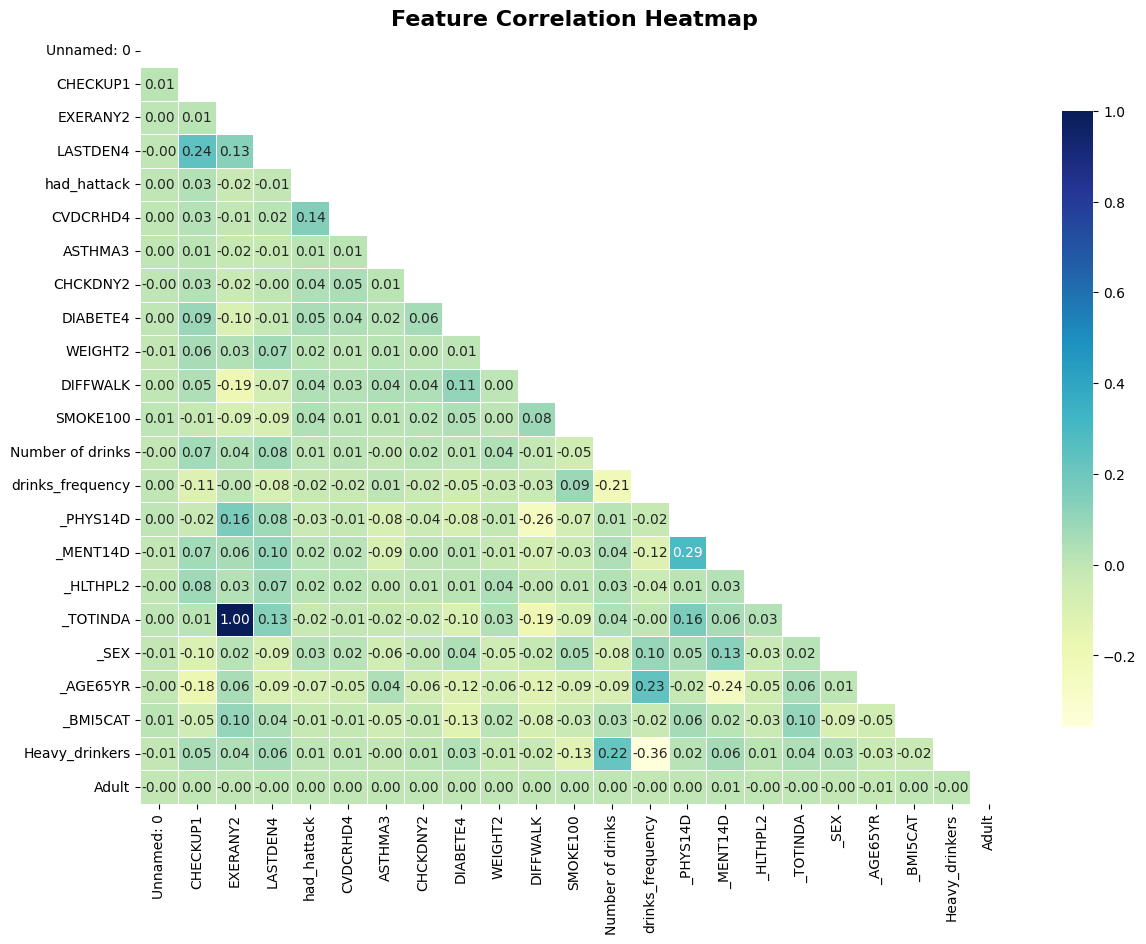

In [ ]:
# ===============================
# 📊 Feature Correlation Heatmap
# ===============================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv("preprocessed.csv")  # change file name as needed

# Compute correlation matrix
corr = df.corr(numeric_only=True)

# Set up figure
plt.figure(figsize=(14, 10))

# Create upper-triangle mask for better look
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot heatmap
sns.heatmap(
    corr,
    mask=mask,
    annot=True,           # show correlation values
    fmt=".2f",            # 2 decimal places
    cmap="YlGnBu",        # blue-green palette
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Feature Correlation Heatmap", fontsize=16, fontweight="bold")
plt.show()
